![image](https://raw.githubusercontent.com/IBM/watson-machine-learning-samples/master/cloud/notebooks/headers/watsonx-Prompt_Lab-Notebook.png)

# Efficient Data Labeling in Label Sleuth for Binary Classification in watsonx

#### Disclaimers

- Use only Projects and Spaces that are available in watsonx context.

# Overview

## Audience

This notebook is part of a series of notebooks, designed to guide you on how to utilize watsonx.ai Large Language Models (LLMs) for text classification.

The scenario considered here assumes you have access to _unlabeled_ text data and would like to quickly develop a binary classifier over these data and evaluate its performance. For example, when confronted with an aggregation of product reviews, the objective could be to identify reviews focused on a particular product, despite the lack of any labeled annotations.

## Learning goal

- The goal of this notebook is to provide an end-to-end step-by-step walkthrough of smart collection of labeled data for a binary text classification task.
- We provide a detailed guide to work with [Label Sleuth](https://www.label-sleuth.org), an IBM open-source platform that leverages active learning for efficient labeled data collection for text classification.
- The notebook is backed by empirical evidence over 6 benchmarks showing that when tuning a Flan-t5-xl over the labeled data collected via Label Sleuth active learning algorithms, there is an average improvement of 7 points in macro-f1 compared to tuning the same model on labeled data which is collected at random, and average improvement of 24 points compared to zero-shot classification with the same model. In addition, the results are comparable on average to those that are achieved by tuning the same model on 5 times more text elements collected at random for annotation.

## Contents

This notebook contains the following parts:

- [Setup](#setup)
- [Real World Example in Label Sleuth](#real_world_example)
- [Benchmark Results](#benchmark)


<a id="setup"></a>
# Setup

## Install dependencies

## Access Label Sleuth

Label Sleuth is a no-code easy-to-use platform that enables efficient labeled data collection and automatic model training, via an intuitive UI. It allows you to build a working classifier for one category (in a binary setup) or a set of categories (in a multi-class setup) in just a few minutes with no prior knowledge in machine learning.

Currently, you can access Label Sleuth by a local installation.




### Install Label Sleuth

Follow the following steps to install Label Sleuth (for more information, please refer to [Label Sleuth open source web page](https://www.label-sleuth.org/)):
1. Set up your python virtual environment by executing the following commands from your terminal:
   
   ```conda create --yes -n label-sleuth python=3.10```
   
   ```conda activate label-sleuth```
3. Install Label Sleuth by running:
   
   ```pip install label-sleuth```

### Launch Label Sleuth

Run the following command in your terminal (this may take up to 2 minutes for the first time):


```python -m label_sleuth.start_label_sleuth --config_path watsonx_config.json```


and then open ```localhost:8000``` in your browser.

Note: The `watsonx_config.json` argument is not covered in the official documentation of Label Sleuth.

<a id="real_world_example"></a>
# Real world example - complaints classification

For initiating the process of labeled data collection, one needs a corpus of *unlabaled data*.

The unlabeled data should contain a mandatory column named `text`, containing the text examples. Additionally you can add an optional column entitled `document_id` containing an identifier of the document associated with each text.

It is recommended to use a large corpus of unlabeled data, especially when the prior of the desired category in the dataset is low. In a raw corpus, most of the examples are expected to be negative, so we need to have enough positive examples for the system to suggest for labeling. Having a dataset with at least 50K examples is usually enough.

To illustrate labeled data collection and the use of PT on binary data, we will use a subset of the CFPB (Consumer Financial Protection Bureau) dataset, available in our repository (for more details about the dataset [click here](https://www.consumerfinance.gov/data-research/consumer-complaints/)). This dataset originally contains millions of real complaints associated with 9 different products (topics). In this notebook we focus on the *credit card* topic, and aim to develop a classifier that identifies complaints that discuss credit cards.

Naturally, one can replace these data with any other dataset and run the notebook.

## Download CFPB data

First, download the CFPB data from [this repository](https://github.com/IBM/watson-machine-learning-samples/blob/master/cloud/data/cfpb_complaints/cfpb_compliants.csv). Open the csv file and rename the column `narrative` to `text`. The `product` column is ignored, as we only use the texts in Label Sleuth. This dataset consist of ~27K text elements, and some of the text elements are eligible positive examples towards the *credit card* topic.

## Upload unlabeled data to Label Sleuth

Upload the csv file to Label Sleuth:

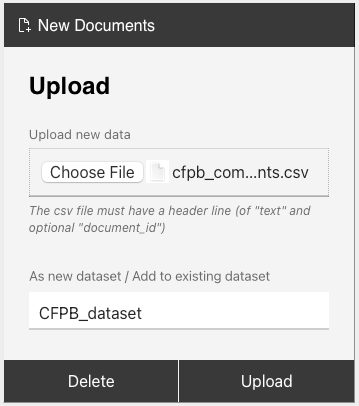

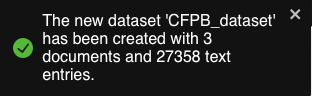

## Create and launch a workspace

Create and launch a new workspace by giving it a name, selecting the dataset uploaded in the previous step, setting the model to `Binary`, and clickling `Create & Go`:

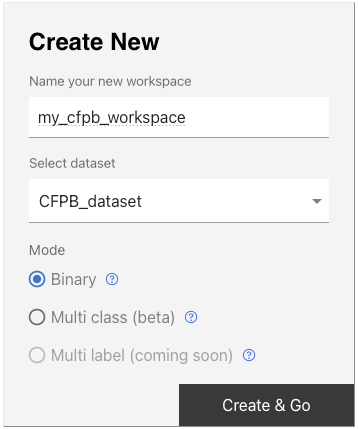

## Define the category

Initially, there are no categories defined in the system.

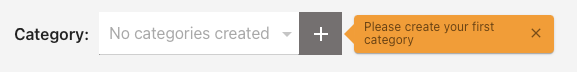

Add your category by clicking on the plus sign:

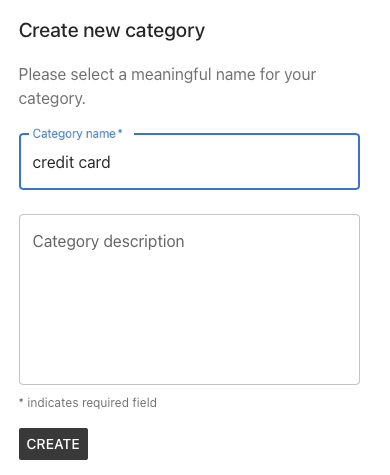

Give your category a semantically meaningful name. Here are some tips for choosing a category name:

* Keep it concise, 5 words at most.
* Refrain from typos, ungrammatical structures and non-ascii characters.
* When using an acronym, enter both the acronym and the full phrase, separated by ":".

The UI allows to add a category description. For now, it is not needed.

In this example, we will build a classifier to identify whether or not the text discusses the category *credit card*.


## Label an initial seed of examples to train the first model

Once your category is created, you can start labeling examples for this category. You need to label at least 5 positive examples, 10 negative examples and 20 examples in total to train the first model to be used in the active learning process. You can see your labeling progress on the left panel. 

Since some categories can be scarse in the unlabeled data, labeling examples one by one is not always effective to pinpoint positive examples, and one may label a lot of negative examples before detecting enough positives. To speed your labeling process, you can use the query search mechanism that allows you to query for all examples that contain some text. Assuming that some categories are highly correlated with some keywords, this mechanism enables you to retrieve texts that are enriched with positive examples for the category you are interested in.
For instance, you can query for *credit card* to retrieve examples that are potentially more relevant to that category.  

To use the query mechanism, enter your query in the search pane on the top of the right panel. 

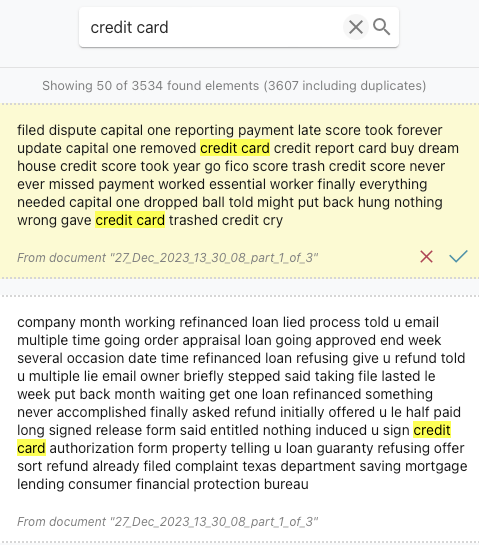

Next, go over the results and label the relevant examples as either positive or negative for your category.

You can run several queries until you labeled enough examples. On the left panel you can follow your labeling progress with the number of positive and negative examples.

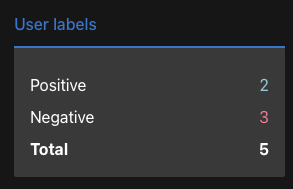

Once you label enough examples, the system starts training a model.

## Curate examples via an active learning process

Once you complete labeling enough examples, Label Sleuth will train a light-weight model. The model is trained on sentence BERT representations of these labeled examples. The first active learning cycle can take between several minutes to up to an hour, depending on your hardware and the size of your unlabeled data, but the next training iterations will be significantly faster since some preprocessing of the unlabeled texts is performed only once, towards the first iteration. You will see an indication that the model is training, and while waiting you can continue labeling more examples, if you wish.

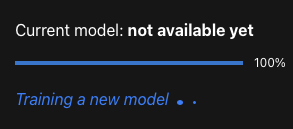

When the training is done, you will notice that the current model is the first version after training. 

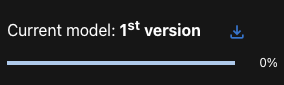


Once the model training is done, you will be able to see its predictions on your unlabeled data. In the "Label next" panel (on the right) you will get a list of examples that the system selected for you to label. These examples are selecred using Label Sleuth active learning algorithm, as the most informative examples to be added to the labeled data, towards the next iteration of training the model.

After each active learning iteration Label Sleuth will train a new light-weight model with all the accumulated labeled data, so each labeling iteration improves your model.

You should aim at labeling 200 examples to curate enough labeled data that can then be used to tune a model in watsonx.ai. Usually, 200 examples are enough, but if you have more time to dedicate for data collection, labeling more than that would usually further improve the quality of the trained model.

## Download the labeled examples
Once you have enough labeled data you can download all the data you labeled by clicking on *Download* under *Workspace labeled data*:

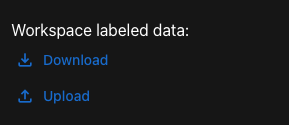

Once you download the labeled data, proceed to the [Prompt Tuning Binary Classification notebook](https://dataplatform.cloud.ibm.com/exchange/public/entry/view/5be4192d-a48d-4b9d-b1e0-815ba51e6976?context=wx) for tuning a model over the labeled data in watsonx.ai.


The downloaded csv contains a column for your category called `category_name` (in a single workspace you can have labeled data for several categories), and additional column for the label. Positive examples are marked with a `True` label, and negative examples are marked with `False`.

In case you have collected labeled data for multiple categories, use the following code to filter the csv and keep only elements associated with the category you wish you classify.

In [1]:
import pandas as pd
import os

In [2]:
input_dir = ""
input_file = ""
downloaded_csv = os.path.join(input_dir, input_file)
category_name = "credit card"

df = pd.read_csv(downloaded_csv)
df = df[df['category_name'] == category_name]
output_path = os.path.join(input_dir, category_name + "_" + input_file)
df.to_csv(output_path)

<a id="benchmark"></a>
# Benchmark Results 

The aim of the following evaluation is to simulate the flow described in this notebook. For each dataset, we do 10 active learning iterations in Label Sleuth, resulting in 200 labeled instances. We compare the performance achieved by running PT with a Flan-t5-xl model on these labeled instances to:
- PT with a Flan-t5-xl model on 200 labeled examples selected at random.
- PT with a Flan-t5-xl model on on 1000 labeled examples selected at random (i.e., 5 times more data).
- Zero-shot classification using Flan-t5-xl. 

The evaluation is performed over 6 benchmark datasets, each dataset containing several categories. For each category we train and evaluate a binary classification model, and for each dataset the result we report is the macro-f1 average on all its categories. For each category, we consider the macro-f1 result over 3 seeds.

As depicted in the table below, PT with active learning provides a significant improvement in almost all datasets compared to zero-shot and PT over randomly selected examples in the same quantity, gaining 7 points on average. Moreover, the perfomance of such a PT model is comparable to the performance of a PT model trained on *5 times* more labeled examples selected randomly, thus saving substantial labeling effort. 

More details regarding the datasets: 
- Sentiment Classification is an IBM internal dataset, while the rest are publicly available.
- Testing of all models is done on a separate random sample of 2K examples.
- Banking, News Classification and Ledgar datasets originally contain more than 5 categories. The results reported here are on 5 categories that were selected at random for each dataset.

| Dataset | Number of classes | Zero-shot| PT with 200 randomly selected examples| PT with 1000 randomly selected examples| PT with 200 examples via active-learning (this notebook)|
| --- | :-: | :-:| :-:| :-:| :-:|
|Sentiment Classification|  3 | 0.58 | 0.73 | **0.78** | 0.76 |
|CFPB   | 9  | 0.59 | 0.66 | 0.72 |**0.73** |
|Ledgar (5 classes)|  5  | 0.31 | 0.52 | 0.63 | **0.64** |
|Banking (5 classes) | 5 | 0.41 | 0.76 | 0.84 | **0.86** | 
|News Classification (5 classes) | 5 | 0.46 | 0.53 | **0.57** | **0.57**|
|20 Newsgroup       | 20 | 0.55 | 0.72 | 0.76 | **0.77**|
| ***Mean*** |  | 0.48 | 0.65 | **0.72** | **0.72**|

 

# Summary

Congratulations, you have collected labeled data effectively using Label Sleuth and are now ready to train a model using watsonx!

For more information, please refer to the [Label Sleuth website](https://www.label-sleuth.org/index.html), or proceed to training your model using the [Prompt Tuning Binary Classification notebook](https://dataplatform.cloud.ibm.com/exchange/public/entry/view/5be4192d-a48d-4b9d-b1e0-815ba51e6976?context=wx).

**Author: Lena Dankin**, LM Utilization Team, IBM Research.

Copyright © 2024 IBM. This notebook and its source code are released under the terms of the MIT License.